## Instalar a biblioteca Rapids

Para treinar o algoritmo foi necessário utilizar uma GPU para realizar o trabalho braçal, entretanto, devemos dois fatores em consideração:

* Não possuo uma GPU disponível
* Este código não funcionou no Google Colab

Para usar a GPU realizei o treinamento no notebook do Kaggle, lá temos dois modelos de GPUs disponíveis. Então caso você não possui uma placa gráfica, utilize o Kaggle para treinar o modelo.  

In [ ]:
!nvidia-smi

In [ ]:
# This get the RAPIDS-Colab install files and test check your GPU.  Run this and the next cell only.
# Please read the output of this cell.  If your Colab Instance is not RAPIDS compatible, it will warn you and give you remediation steps.
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/env-check.py

In [ ]:
# This will update the Colab environment and restart the kernel.  Don't run the next cell until you see the session crash.
!bash rapidsai-csp-utils/colab/update_gcc.sh
import os
os._exit(00)

In [ ]:
# Installing RAPIDS is now 'python rapidsai-csp-utils/colab/install_rapids.py <release> <packages>'
# The <release> options are 'stable' and 'nightly'.  Leaving it blank or adding any other words will default to stable.

!python rapidsai-csp-utils/colab/install_rapids.py stable
import os
os.environ['NUMBAPRO_NVVM'] = '/usr/local/cuda/nvvm/lib64/libnvvm.so'
os.environ['NUMBAPRO_LIBDEVICE'] = '/usr/local/cuda/nvvm/libdevice/'
os.environ['CONDA_PREFIX'] = '/usr/local'

# CLUSTERING 

Clustering consiste em agrupar um conjunto de dados com base em suas semelhanças. Ao contrário de métodos de classificação e regressão, estamos lidando com aprendizagem não supervisionada, onde algoritmos compreendem as relações entre um conjunto de dados.


## Aplicação

Podemos aplicar clustering em diversos setores da indústria. Alguns exemplos incluem:

* Segmentação de mercado.
* Análise de rede social.
* Agrupamento de resultados da pesquisa.
* Imagem médica.
* Segmentação de imagens.
* Detecção de anomalias.





## Tipos 

### Clustering baseado em centroide

O clustering baseado em centroide organiza os dados em clusters não hierárquicos, **k-means** é o algoritmo de clustering baseado em centroide mais usado. Os algoritmos baseados em centroide são eficientes, mas sensíveis às condições iniciais e outliers. Neste notebook foi utilizado o k-means, porque ele é um algoritmo de clustering eficiente, eficaz e simples.

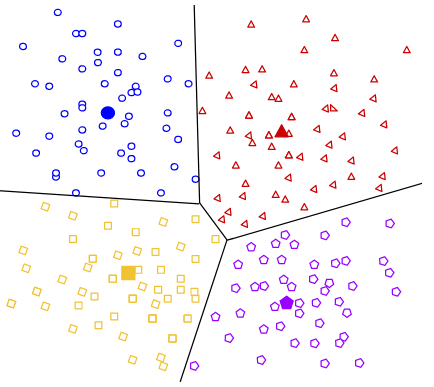

### Clustering baseado em densidade

O clustering baseado em densidade conecta áreas de alta densidade em clusters. Isso permite distribuições de forma arbitrária, desde que as áreas densas possam ser conectadas. Esses algoritmos têm dificuldade com dados de densidades variadas e dimensões altas. Um exemplo deste é o DBSCAN, ele agrupa pontos próximos entre si a partir de uma medida de distância (geralmente distância euclidiana) e um número mínimo de pontos além de marcar  como outliers os pontos que estão em regiões de baixa densidade.

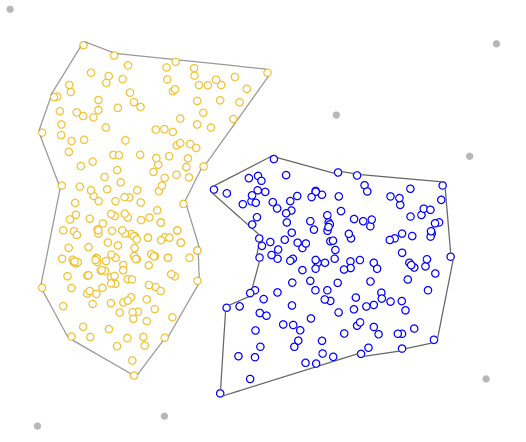


### Clustering baseado em distribuição

Essa abordagem de clustering pressupõe que os dados são compostos de distribuições, como distribuições gaussianas. O algoritmo baseado em distribuição agrupa os dados em distribuições gaussianas. À medida que a distância do centro aumenta, a probabilidade de que um ponto pertence à distribuição diminui. As faixas mostram Essa diminuição na probabilidade. Quando você não souber o tipo de distribuição nos seus dados, use um algoritmo diferente.

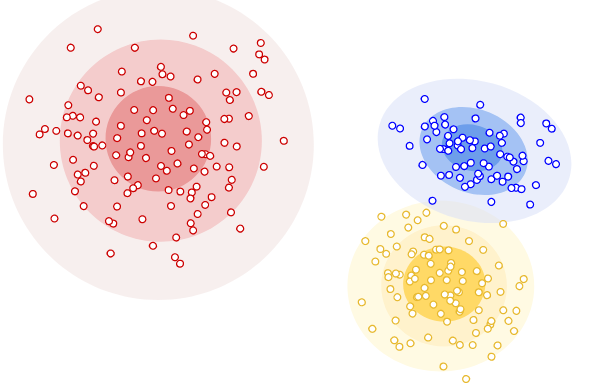

### Clustering hierárquico

O clustering hierárquico cria uma árvore de clusters. O que não é surpreendente é que é adequado para dados hierárquicos, além disso, outra vantagem é que qualquer número de clusters pode ser escolhido cortando a árvore no nível certo.

# Dataset

O conjunto de dados utilizado foi coletados do [Condado de Montgomery](https://data.montgomerycountymd.gov/Public-Safety/Crime/icn6-v9z3) que fica no estado americano de Maryland. O dataset possui as seguintes colunas:

* **Incident ID**: Número de incidente policial.
* **Offence Code**: Offense_Code é o código para uma ofensa cometida, conforme definido pelo National Incident-Based Reporting System (NIBRS) do Programa de Relatórios Uniformes de Crimes (UCR) da Divisão de Serviços de Informações da Justiça Criminal (CJIS).
* **CR Number**: Número do relatório policial. 
* **Dispatch Date / Time**: Data de despacho de oficial de policia até a ocorrência.
* **NIBRS Code**: Códigos NIBRS (National Incident-Based Reporting System) do FBI.
* **Victims**: Vitimas. 
* **Crime Name1**: Denominação do crime. 
* **Crime Name2**: Denominação do crime.
* **Crime Name3**: Denominação do crime.
* **Police District Name**: Distrito de policia. 
* **Block Address**: Endereço do bloco.
* **City**: Cidade.
* **State**: Estado.
* **Zip Code**: Cep.
* **Agency**: Nome da agência de policia.
* **Place**: Descrição do local.
* **Sector**: Nome do setor policial.
* **Beat**: Área de patrulha da policia.
* **PRA**: Police response area (área de resposta policial).
* **Adress Number**: Número da residência.
* **Street Prefix**: Prefixo.
* **Street Sufix**: Sufixo.
* **Street Type**: Tipo de rua. 
* **Start_Date_Time**: Data do início da ocorrência. 
* **End_Date_Time**: Data do final da ocorrência
* **Latitude**: Latitude.
* **Longitude**: Longitude.
* **Police District Number**: Número do distrito policial.
* **Location**: Localização. 

## Importar as bibliotecas 
Primeiramente vamos importas as bibliotecas necessárias. 

In [ ]:
# Bibliotecas para processamento de dados 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
from collections import Counter

# Redução de dimensionalidade 
import umap.umap_ as umap
from sklearn.decomposition import PCA

# Algoritmos para clustering 
from sklearn.cluster import KMeans, MiniBatchKMeans, AgglomerativeClustering, SpectralClustering, DBSCAN, OPTICS, Birch
import plotly.express as px

# plotar gráficos 
from yellowbrick.cluster.elbow import kelbow_visualizer
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn import datasets, mixture, metrics
from sklearn.neighbors import kneighbors_graph

# Rapids libraries
import cudf

import warnings
warnings.filterwarnings("ignore")

# Parte necessária para carregar os dados no Kaggle

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/cluster-kaggle/cluster_kaggle
/kaggle/input/crime-data/Crime.csv


## Carregamento do dataframe 

In [ ]:
df = pd.read_csv('/kaggle/input/crime-data/Crime.csv')
df.head()

,Incident ID,Offence Code,CR Number,Dispatch Date / Time,NIBRS Code,Victims,Crime Name1,Crime Name2,Crime Name3,Police District Name,...,Street Prefix,Street Name,Street Suffix,Street Type,Start_Date_Time,End_Date_Time,Latitude,Longitude,Police District Number,Location
0,201219928,1204,180063894,12/21/2018 09:13:13 PM,120,1,Crime Against Property,Robbery,ROBBERY - STREET-GUN,WHEATON,...,NaN,GEORGIA,NaN,AVE,12/21/2018 09:13:00 PM,NaN,39.036270,-77.049900,4D,"(39.0363, -77.0499)"
1,201301798,5016,200035833,09/13/2020 12:26:58 AM,90Z,1,Crime Against Society,All Other Offenses,OBSTRUCT GOVT - VIOLATION OF A COURT ORDER,GERMANTOWN,...,NaN,COLTRANE,NaN,DR,08/08/2020 05:10:00 PM,08/08/2020 12:00:00 AM,39.277840,-77.211500,5D,"(39.2778, -77.2115)"
2,201221577,5404,190000342,01/03/2019 02:48:47 AM,90D,1,Crime Against Society,Driving Under the Influence,DRIVING UNDER THE INFLUENCE LIQUOR,ROCKVILLE,...,N,GRANDIN,NaN,AVE,01/03/2019 02:48:00 AM,01/03/2019 02:48:00 AM,39.086688,-77.144754,1D,"(39.0867, -77.1448)"
3,201221577,9053,190000342,01/03/2019 02:48:47 AM,90Z,1,Other,All Other Offenses,LITTERING/TRASH DUMPING,ROCKVILLE,...,N,GRANDIN,NaN,AVE,01/03/2019 02:48:00 AM,01/03/2019 02:48:00 AM,39.086688,-77.144754,1D,"(39.0867, -77.1448)"
4,201294935,2303,200027681,07/16/2020 05:29:50 PM,23C,1,Crime Against Property,Shoplifting,LARCENY - SHOPLIFTING,GERMANTOWN,...,NaN,FREDERICK,NaN,RD,07/16/2020 05:29:00 PM,NaN,39.198295,-77.244900,5D,"(39.1983, -77.2449)"


## Entendendo o dataset

### Renomear as colunas

Podemos notar que todas as colunas estão em inglês, afinal os dados são do estado de Maryland, USA. Vamos renomear as colunas para o português, afinal de contas, não moramos na gringa ainda.

In [ ]:
# transforma todas as colunas para letras minúsculas 
df.columns= df.columns.str.lower()

# Renomeia as colunas 
df.rename(columns={'incident id':'id', 'offence code':'cod_crime', 'cr number':'cr_num', 'dispatch date / time':'atendimento', 'nibrs code':'cod_nibrs', 'victims':'vitimas', 'sector':'setor',
                   'crime name1':'nome_crime1', 'crime name2':'nome_crime2', 'crime name3':'nome_crime3', 'police district name':'nome_pol_dist', 'block address':'endereco_bloco',
                   'zip code':'cep', 'address number':'endereco_num', 'street prefix':'prefixo_rua', 'street suffix':'sufixo_rua', 'street type':'tipo_rua', 'police district number':'numero_pol_dist',
                   'start_date_time':'inicio_oco', 'end_date_time':'data_fim', 'city':'cidade', 'state':'estado', 'agency':'agencia', 'location':'localizacao', 'street name':'nome_rua', 'place':'lugar'}, 
          inplace=True)

### Tipo das variáveis 

Primeiramente vamos dar uma olhada nos tipos das variáveis. 

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 318350 entries, 0 to 318349
Data columns (total 30 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   id               318350 non-null  int64  
 1   cod_crime        318350 non-null  object 
 2   cr_num           318350 non-null  int64  
 3   atendimento      269180 non-null  object 
 4   cod_nibrs        318350 non-null  object 
 5   vitimas          318350 non-null  int64  
 6   nome_crime1      318064 non-null  object 
 7   nome_crime2      318064 non-null  object 
 8   nome_crime3      318064 non-null  object 
 9   nome_pol_dist    318257 non-null  object 
 10  endereco_bloco   291344 non-null  object 
 11  cidade           317075 non-null  object 
 12  estado           318350 non-null  object 
 13  cep              315168 non-null  float64
 14  agencia          318350 non-null  object 
 15  lugar            318350 non-null  object 
 16  setor            316486 non-null  obje

Algumas colunas são do tipo int64,  iremos transformá-las para objeto já que não serão feitas operações matemáticas com as mesmas.

In [ ]:
df[['id', 'cr_num', 'cep', 'endereco_num']] = df[['id', 'cr_num', 'cep', 'endereco_num']].astype('object')

### Valores nulos 

In [ ]:
null = (df.isnull().sum() / len(df)) * 100
null = null.drop(null[null == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :null})
missing_data

,Missing Ratio
sufixo_rua,98.286477
prefixo_rua,95.521282
data_fim,52.905293
atendimento,15.445265
endereco_bloco,8.483116
endereco_num,8.451390
cep,0.999529
beat,0.585519
setor,0.585519
cidade,0.400503


Colunas com valores acima de 50% serão dropadas e as outras terão seu valor NaN substituido por None 

In [ ]:
# Dropa colunas com valores nulos superiores a 50%
df.drop(['sufixo_rua', 'prefixo_rua', 'data_fim'], axis=1, inplace=True)

# Substitui os valores nulos por None
for col in ('atendimento', 'endereco_bloco', 'endereco_num', 'cep', 'setor', 'beat', 'cidade', 'tipo_rua', 'nome_crime1', 'nome_crime2',
            'nome_crime3', 'pra', 'nome_pol_dist', 'nome_rua'):
  df[col] = df[col].fillna('None')

## Analisar longitude e latitude

O dataset também contém informações de latitude e longitude. Para entender a relação entre estas variáveis, foi plotado um scatter plot.

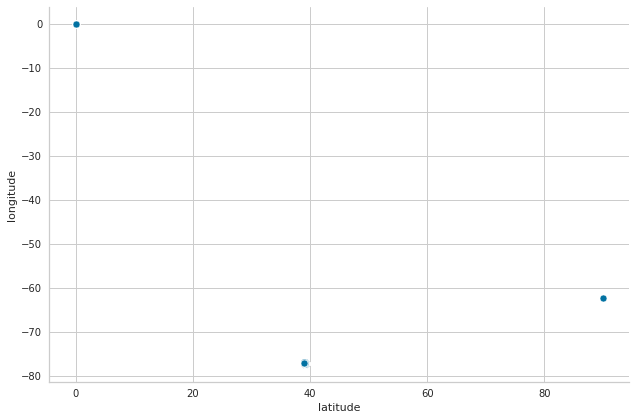

In [ ]:
sns.relplot(data=df, x='latitude', y='longitude', height=6, aspect=1.5);

Este gráfico não é o scatter plot que estamos acostumados a ver, temos 3 aglomerados de dados. Vemos que um aglomerado possui as coordenadas 0,0 o que é impossível de acontecer, já que nossos dados são do estado de Maryland, estas coordenadas são de um local no meio do mar. Temos também longitudes com valores de 90°, o que é muito estranho já que as coordenadas de Maryland são ≅ 39° N, 76.6° W.

In [ ]:
# Conferindo os valores 
df.latitude.describe()

count    318350.000000
mean         37.986500
std           6.450590
min           0.000000
25%          39.019697
50%          39.072215
75%          39.141923
max          90.000000
Name: latitude, dtype: float64

Para consertar as anomalias, as coordenadas que possuem 0 e 90 foram dropadas.

In [ ]:
df.drop(df.loc[df.latitude == 0].index, inplace=True)
df.drop(df.loc[df.latitude == 90].index, inplace=True)

# vamos resetar os indexes 
df.reset_index(inplace=True)

Agora vamos ver o resultado.

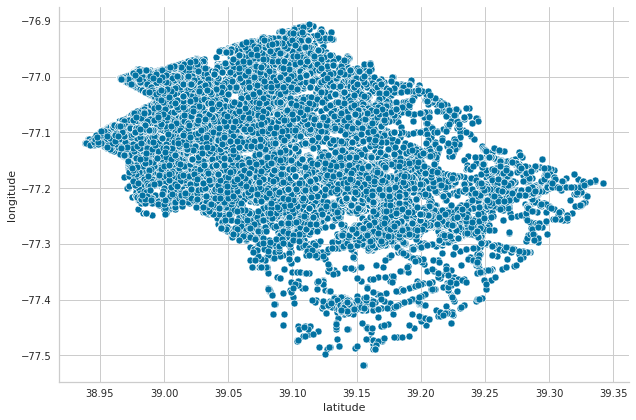

In [ ]:
sns.relplot(data=df, x='latitude', y='longitude', height=6, aspect=1.5);

Agora sim, temos um gráfico decente, um scatter plot bem distribuído sem nenhum agrupamento indesejado.

## Lidando com datas

Temos algumas colunas que marcam as datas de inicío das ocorrências, porêm as colunas são do tipo 'object'. Iremos converter estas colunas para 'datetime', realizando estas conversôes, futuras análises ficarâo mais fáceis. 

In [ ]:
# converte de objeto para data 
df['atendimento'] = pd.to_datetime(df['atendimento'], errors='coerce')
df['inicio_oco'] = pd.to_datetime(df['inicio_oco'], errors='coerce')

## Cardinalidade 

Nosso dataset é composto em sua maioria por variáveis categóricas, entretanto a maioria dos algoritmos de Machine Learning não processam este tipo de variável..Para lidar com este problema, o manual do machine learning manda utilizar [**OneHotEncoder**](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) ou [**get_dummies**](https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html). mas quando temos variáveis com cardinalidade alta (excesso de valores únicos) se aplicarmos um get_dummies teremos um dataset com um número excessivo de colunas, prejudicado, e muito, o treinamento do modelo.

Não precisamos das colunas **id**, **cr_num** e **atendimento**. 

In [ ]:
df.drop(['id', 'cod_crime', 'atendimento', 'cr_num', 'pra'], axis=1, inplace=True)

Para diminuir a cardinalidade, vamos utilizar uma função milagrosa que mantém os elementos mais frequentes de uma coluna e atribui uma variável para o restante dos elementos [link](https://towardsdatascience.com/dealing-with-features-that-have-high-cardinality-1c9212d7ff1b).

O balanço foi positivo, conseguimos reduzir drasticamente a cardinalidade da maioria das variáveis, mas ainda tivemos que deletar **inicio_oco**, **endereco_bloco**, **endereco_num**, **nome_rua**, **localizacao**, **nome_crime1** e **nome_crime2**,  porque mesmo aplicando a função, suas cardinalidades continuaram altas.

In [ ]:
df = df.drop(['inicio_oco', 'endereco_bloco', 'endereco_num', 'nome_rua', 'localizacao', 'nome_crime1', 'nome_crime2'], axis=1)

In [ ]:
def cumulatively_categorise(column, threshold=0.85, return_categories_list=True):
  # Encontra o valor limite usando a porcentagem e o número de instâncias na coluna
  threshold_value = int(threshold*len(column))
  # Inicializa uma lista vazia para novas categorias minimizadas
  categories_list=[]
  # Inicializa uma variável para calcular a soma das frequências
  s = 0
  # Crie um dicionário contador no formato valor_exclusivo: frequência
  counts = Counter(column)

  # Faz um loop pelo nome da categoria e sua frequência correspondente após classificar as categorias em ordem decrescente de frequência
  for i, j in counts.most_common():
    # Adiciona a frequência à soma global
    s += dict(counts)[i]
    # Anexa o nome da categoria à lista
    categories_list.append(i)
    # Verifica se a soma global atingiu o valor limite, se sim, interrompe o loop
    if s >= threshold_value:
      break
  # Acrescenta a categoria Outro à lista
  categories_list.append('Other')

  # Substitue todas as instâncias que não estão nas novas categorias por Outros
  new_column=column.apply(lambda x: x if x in categories_list else 'Other')

  # Retorna a coluna transformada e os valores exclusivos se return_categories=True
  if(return_categories_list):
    return new_column, categories_list
  # Retorna apenas a coluna transformada se return_categories=False
  else:
    return new_column

In [ ]:
# Colunas que terão a cardinalidade reduzida 
cols = ['cod_nibrs', 'nome_crime3', 'cidade', 'cep', 'lugar', 'beat', 'tipo_rua', 'numero_pol_dist']

for col in cols:
  transformed_column, new_category_list = cumulatively_categorise(df[col], return_categories_list=True)
  df[col] = transformed_column

Vamos comparar as cardinalidades de antes e depois 

In [ ]:
df.nunique()

index              309429
cod_nibrs              16
vitimas                10
nome_crime3            40
nome_pol_dist          10
cidade                  8
estado                 10
cep                    21
agencia                 8
lugar                  25
setor                  16
beat                   31
tipo_rua                9
latitude            45381
longitude           40111
numero_pol_dist         7
dtype: int64

Conseguimos reduzir drasticamente a cardinalidade dos dados mantendo apenas as variáveis que mais aparecem no dataset, o restante virou uma variável chamada 'other'

In [ ]:
# Codifica as variáveis categóricas 
dummy_df = pd.get_dummies(df)
dummy_df

,index,vitimas,latitude,longitude,cod_nibrs_13B,cod_nibrs_220,cod_nibrs_23C,cod_nibrs_23D,cod_nibrs_23F,cod_nibrs_23G,...,tipo_rua_RD,tipo_rua_ST,tipo_rua_WAY,numero_pol_dist_1D,numero_pol_dist_2D,numero_pol_dist_3D,numero_pol_dist_4D,numero_pol_dist_5D,numero_pol_dist_6D,numero_pol_dist_Other
0,0,1,39.036270,-77.049900,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,1,1,39.277840,-77.211500,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,2,1,39.086688,-77.144754,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,3,1,39.086688,-77.144754,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,4,1,39.198295,-77.244900,0,0,1,0,0,0,...,1,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
309424,318344,1,39.113490,-77.187300,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,1,0
309425,318346,1,39.065940,-77.074800,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
309426,318347,1,38.991160,-77.001800,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
309427,318348,1,39.000620,-77.135800,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


Caso não tivessemos usado a função para reduzir a cardinalidade, ao invés de 205 colunas, teriámos mais de 900, o que aumentaria o tempo de treino drastiacamente. 

### Importância da normalização 

Os primeiros testes foram realizados em normalização, entretanto não gostei dos resultados. Após a normalização o tempo de processamento melhorou de maneira exponencial e o silhouette score (métrica de avaliação) obteve uma melhora de mais de 10%.

In [ ]:
scaled = pd.DataFrame(RobustScaler().fit_transform(dummy_df), columns=dummy_df.columns)
scaled.head(5)

,index,vitimas,latitude,longitude,cod_nibrs_13B,cod_nibrs_220,cod_nibrs_23C,cod_nibrs_23D,cod_nibrs_23F,cod_nibrs_23G,...,tipo_rua_RD,tipo_rua_ST,tipo_rua_WAY,numero_pol_dist_1D,numero_pol_dist_2D,numero_pol_dist_3D,numero_pol_dist_4D,numero_pol_dist_5D,numero_pol_dist_6D,numero_pol_dist_Other
0,-1.024742,0.0,-0.328651,0.334229,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,-1.024736,0.0,1.679819,-0.642498,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,-1.024729,0.0,0.090533,-0.239078,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-1.024723,0.0,0.090533,-0.239078,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-1.024716,0.0,1.018466,-0.844369,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


## PCA

Antes do clustering vamos reduzir a dimensionalidade do código, primeiramente vamos usar PCA. Para escolhermos o numero de componentes ideais, vamos plotar o total de variância que pode ser explicada pelo algoritmo. Ao invés de escrevermos uma infinidade de linhas para plotar um gráfico, vamos usar a biblioteca PLOTLY para conseguir resultados rápidos 

In [ ]:
# PCA foi feito utilizando a biblioteca rapids para diminuir o seu tempo de processamento

from cuml import PCA
from cuml.decomposition import PCA

In [ ]:
pca = PCA()
pca.fit(scaled)
exp_var_cumul = np.cumsum(pca.explained_variance_ratio_)

px.area(
    x=range(1, exp_var_cumul.shape[0] + 1),
    y=exp_var_cumul,
    labels={"x": "# Components", "y": "Explained Variance"}
)

O objetivo de reduzir a dimensionalidade de um dataset é ter uma melhor noção de como os dados estão representados e otimizar o treinamento. Como o nosso dataset é complexo, o PCA não consegue fazer um serviço muito bom. Para termos 95% da variância do dataset precisamos de 84 colunas o que inviabiliza a escolha. Vamos partir para uma outra abordagem, UMAP. Para mais informações sobre o UMAP, só acessar este [link](https://umap-learn.readthedocs.io/en/latest/).

## Umap

Como mencionado anteriormente, nosso dataset é grande. O UMAP tem um tempo de processamento maior do que o PCA, por este motivo utilizamos o UMAP com processamento de GPU. Mais informações neste [link](https://docs.rapids.ai/api/cuml/nightly/api.html#umap).

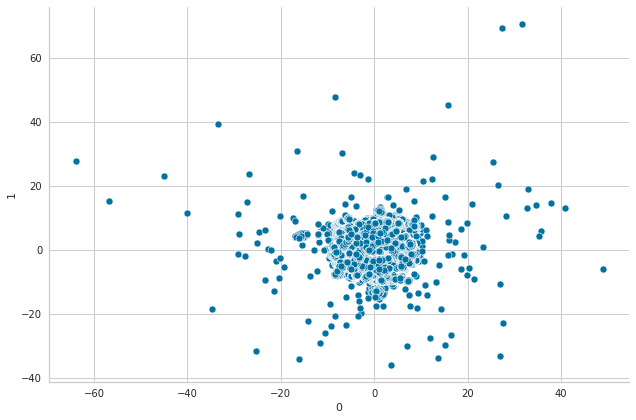

In [ ]:
# importa o umap 
from cuml.manifold import UMAP

clusterable = pd.DataFrame(UMAP(n_neighbors=300, min_dist=0.0,  n_components=2, random_state=42, spread=0.5).fit_transform(scaled))
sns.relplot(data=clusterable, x=0, y=1, height=6, aspect=1.5);

Por alguma razão, quando é utilizado Umap da biblioteca Rapids da nvidia, não possuímos um agrupamento dos dados, apenas uma grande mancha com alguns dados esparsos, o que é bem diferentes do Umap convencional. Se utilizando a GPU os dados ficam dispersos, quando utilizamos uma cpu os dados a coisa muda de figura. Por este motivo o Umap convencional foi escolhido, o processamento demora bastante, entretando temos resultados bem melhores. 

In [ ]:
# este código foi usado para realizar a redução de dimensionalidade sem usar o cuml
# pois os clusters são diferentes
'''
from sklearn.model_selection import train_test_split

data1, data2 = train_test_split(scaled, random_state=5, train_size=0.5, shuffle=False)

clusterable1 = pd.DataFrame(umap.UMAP(n_neighbors=300, min_dist=0.0,  n_components=2, random_state=42).fit_transform(data1))
clusterable2 = pd.DataFrame(umap.UMAP(n_neighbors=300, min_dist=0.0,  n_components=2, random_state=42).fit_transform(data2))
data = pd.concat([clusterable1, clusterable2], ignore_index=True)
data.to_csv('cluster_kaggle')

Os dados foram divididos em 2 datasets, após isso o umap foi aplicado em ambos. Com o resultado em mãos, ambos os datasets foram unidos novamente. 

## Agrupando os dados

Como mencionado anteriormente, foi utilizado o umap convencional para o processamento dos dados. Este processamento demorou horrores, então para não passar o mesmo trabalho duas vezes, o dataset reduzido foi salvo. 

Lembrando que o correto seria utilizar uma GPU, mas por algum motivo que não sei explicar os resultados deram tão diferentes. 

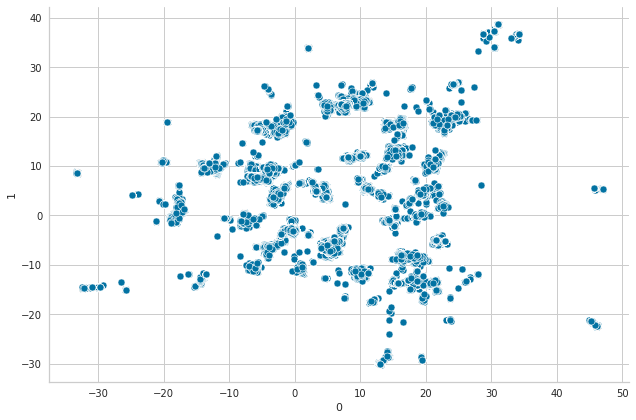

In [ ]:
# Carrega os dados salvos
cluster_data = pd.read_csv('/kaggle/input/cluster-kaggle/cluster_kaggle')

# Surge uma coluna Unnamed: 0 quando carregamos novamente, vamos dropar esta coluna 
cluster_data.drop('Unnamed: 0', axis=1,inplace=True)

# Plota o dataset
sns.relplot(data=cluster_data, x='0', y='1', height=6, aspect=1.5);

Nosso dataset está agrupado descentemente, entretanto existem muitos pontos soltos que não fazem parte de aglomerado nenhum. vamos usar o **dbscan** para reconhecer estes outliers. Por sorte, DBScan também está incluido no arsenal da biblioteca **cuml**.


[W] [23:58:11.866381] Batch size limited by the chosen integer type (4 bytes). 8822 -> 6940. Using the larger integer type might result in better performance


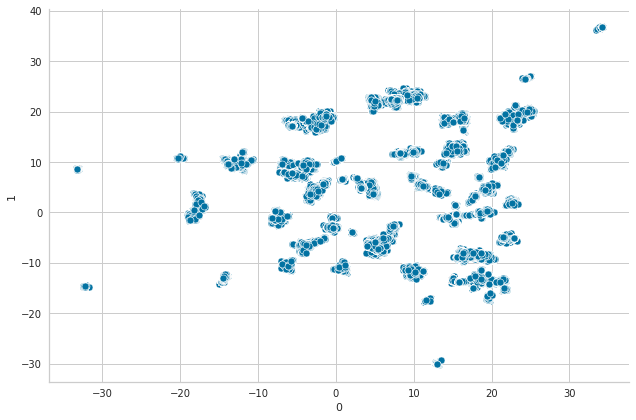

In [ ]:
from cuml import DBSCAN
from cuml.cluster import DBSCAN

# instancia o dbscan
dbscan = DBSCAN(min_samples = 500)
# fita o algoritmo e realiza as previsões 
pred = dbscan.fit_predict(cluster_data)
# criamos a coluna 'pred' com os valores preditios 
cluster_data['pred'] = pred
# no dbscan clusters com valores -1 são considerados outliers, vamos gravar o index detses valores  
drop = cluster_data[cluster_data.pred == -1].index
# dropamos os outliers, estes valores também devem ser dropados no dataser original 
cluster_data.drop(drop, inplace=True)
# plota o novo dataset
sns.relplot(data=cluster_data, x='0', y='1', height=6, aspect=1.5); 


Temos uma distribuição mais limpa dos dados. O próximo passo é selecionar qual algoritmo melhor se adapta ao nosso dataset. Para isso criaremos uma amostra que será usada nos testes.

,0,1
count,1759.000000,1759.000000
mean,6.004075,5.549505
std,11.738618,11.501123
min,-33.308487,-30.219519
25%,-3.249802,-5.026390
50%,7.214209,6.375820
75%,16.135539,16.690827
max,34.180650,36.842384


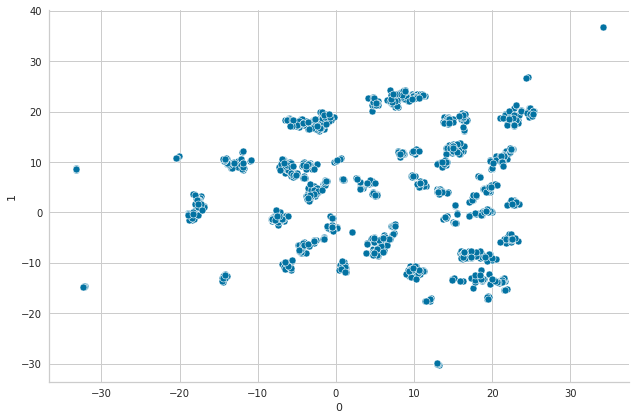

In [ ]:
# Retira uma amostra de 6% do dataset
sample_cluster = cluster_data.sample(frac=0.006, random_state=20)
sns.relplot(data=sample_cluster, x='0', y='1', height=6, aspect=1.5);
sample_cluster.drop('pred', axis=1, inplace=True)
sample_cluster.describe()

A distribuição da nossa amostra é muito parecida com a original. Agora vamos descobrir o algoritmo que melhor se adapta. Os algoritmos escolhidos foram:

* [KMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)
* [Mini Batch KMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.MiniBatchKMeans.html)
* [Spectral Clustering](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.SpectralClustering.html)
* [DBScan](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html)
* [OPTICS](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.OPTICS.html)
* [Agglomerative Clustering](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html)
* [Agglomerative Clustering](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html) 
* [Birch](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.Birch.html)
* [Gaussian Mixture](https://scikit-learn.org/stable/modules/mixture.html#:~:text=A%20Gaussian%20mixture%20model%20is,Gaussian%20distributions%20with%20unknown%20parameters.) 

In [ ]:
%%time
clusters = [13, 14, 15]
resultado = pd.DataFrame()

# Create cluster objects
for cluster in clusters:
  k_means = KMeans(n_clusters = cluster)

  two_means = MiniBatchKMeans(n_clusters = cluster)

  spectral = SpectralClustering(n_clusters = cluster)

  dbscan = DBSCAN(min_samples = 5)

  optics = OPTICS()

  ac = AgglomerativeClustering()

  birch = Birch(n_clusters = cluster)

  gmm = mixture.GaussianMixture(n_components = cluster)

  clustering_algorithms = (("Kmeans", k_means),
      ("MiniBatch KMeans", two_means),
      ("Spectral Clustering", spectral),
      ("DBSCAN", dbscan),
      ("BIRCH", birch),
      ("Gaussian Mixture", gmm),
      ('Optics', optics),
      ('AglomerativeClustering', ac)
  )

  metrica = []

  for name, algorithm in clustering_algorithms:
      labels = algorithm.fit_predict(sample_cluster)
      metrica.append(metrics.silhouette_score(sample_cluster, labels))
  
  resultado[cluster] = metrica

nome = ['Kmeans','MiniBatch KMeans', 'Spectral Clustering', 'DBSCAN', 'BIRCH', 'Gaussian Mixture', 'optics', 'AglomerativeClustering']
resultado.index = nome

resultado

CPU times: user 13min 1s, sys: 5min 14s, total: 18min 15s
Wall time: 9min 49s


,13,14,15
Kmeans,0.538192,0.533277,0.543176
MiniBatch KMeans,0.510379,0.511444,0.512626
Spectral Clustering,0.044480,0.278722,0.305813
DBSCAN,0.482542,0.482542,0.482542
BIRCH,0.498800,0.523055,0.537229
Gaussian Mixture,0.459111,0.485461,0.513136
optics,0.173098,0.173098,0.173098
AglomerativeClustering,0.354775,0.354775,0.354775


De acordo com o nosso teste os dois melhores algoritmos para utilizarmos são: **Kmeans** e **MiniBatch KMeans**, entretanto KMeans possui implementação pela biblioteca **Rapids**.

## Kmeans 

O KMeans agrupa os dados tentando separar as amostras em grupos de variância igual, minimizando um critério conhecido como inércia ou soma dos quadrados dentro do cluster. Primeiramente vamos dar uma olhada no dataset. 

In [ ]:
cluster_data.head(5)

,0,1,pred
0,-18.320593,-1.079636,0
1,10.635567,5.320854,1
2,17.303791,-7.664558,2
3,19.287182,-8.282428,2
4,34.264606,36.722570,3


Temos a coluna **pred** que foi adicionada quando rodamos o Dbscan para deletar outliers. Vamos dropar esta coluna pois ela não é mais útil. 

In [ ]:
cluster_data.drop('pred', axis=1, inplace=True)

In [ ]:
# Executa o Kmeans 

from cuml import KMeans
from cuml.cluster import KMeans

kmclust = KMeans(n_clusters=15)
labels = kmclust.fit_predict(cluster_data)

Agora que já temos os clusters, vamos adicionar as labels ao nosso dataset original. Entretanto lá atrás nos dropamos os outliers encontrados pelo o dbscan, devemos fazer a mesma coisa no dataset original. 

In [ ]:
df.drop(drop, inplace=True)
df['cluster'] = labels

In [ ]:
df.head()

,index,cod_nibrs,vitimas,nome_crime3,nome_pol_dist,cidade,estado,cep,agencia,lugar,setor,beat,tipo_rua,latitude,longitude,numero_pol_dist,cluster
0,0,Other,1,Other,WHEATON,SILVER SPRING,MD,20902.0,MCPD,Other,L,4L2,AVE,39.036270,-77.049900,4D,11
1,1,90Z,1,Other,GERMANTOWN,Other,MD,Other,MCPD,Parking Lot - Residential,M,Other,DR,39.277840,-77.211500,5D,12
2,2,90D,1,DRIVING UNDER THE INFLUENCE LIQUOR,ROCKVILLE,ROCKVILLE,MD,20850.0,RCPD,Street - In vehicle,A,1A3,AVE,39.086688,-77.144754,1D,8
3,3,90Z,1,Other,ROCKVILLE,ROCKVILLE,MD,20850.0,RCPD,Street - Other,A,1A3,AVE,39.086688,-77.144754,1D,8
4,4,23C,1,LARCENY - SHOPLIFTING,GERMANTOWN,GERMANTOWN,MD,20876.0,MCPD,Retail - Department/Discount Store,M,5M1,RD,39.198295,-77.244900,5D,9


## Conclusão

Neste notebook realizamos clustering usando um dataset real. Com este dataset tivemos a oportunidade de usar uma função para reduzir a cardinalidade, descobrir inconsistências, aprender a utilizar a biblioteca rapids, utilizar uma métrica de avaliação para um algoritmo de clustering e usar o dbscan para detecção de outliers.